# Runtime Comparison: Sequential vs. Async DORAnetMCTS

This notebook compares the runtime performance of sequential (`DORAnetMCTS`) and asynchronous (`AsyncExpansionDORAnetMCTS`) implementations for the target molecule **5,6-dihydroyangonin**.

**Target molecule**: 5,6-dihydroyangonin  
**SMILES**: `COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O`

## 1. Setup and Imports

In [12]:
import re
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
from rdkit.Chem import rdMolDescriptors

# Matplotlib styling
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.autolayout'] = True
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Repository root
REPO_ROOT = Path('../').resolve()
print(f"Repository root: {REPO_ROOT}")

Repository root: /Users/yashchainani/Desktop/PythonProjects/RL_agents_for_retrosynthesis


## 2. Define Target Molecule

Target: 5,6-dihydroyangonin
SMILES: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
Molecular formula: C15H16O4
Molecular weight: 260.29 g/mol


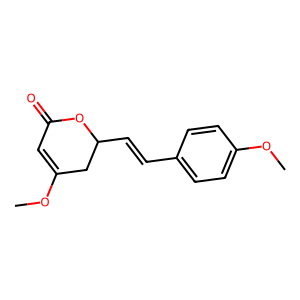

In [13]:
# 5,6-dihydroyangonin
TARGET_SMILES = "COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O"
TARGET_NAME = "5,6-dihydroyangonin"

# Validate SMILES
target_mol = Chem.MolFromSmiles(TARGET_SMILES)
if target_mol is None:
    raise ValueError(f"Invalid SMILES: {TARGET_SMILES}")

print(f"Target: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"Molecular formula: {rdMolDescriptors.CalcMolFormula(target_mol)}")
print(f"Molecular weight: {Descriptors.MolWt(target_mol):.2f} g/mol")

# Display molecule
Draw.MolToImage(target_mol, size=(300, 300))

## 3. Load Benchmark Results

In [14]:
def parse_benchmark_file(filepath):
    """
    Parse a benchmark result text file and extract metrics.
    
    Returns a dictionary with the extracted values.
    """
    with open(filepath, 'r') as f:
        content = f.read()
    
    # Extract metrics using regex
    def extract_value(pattern, text, default=None):
        match = re.search(pattern, text)
        return match.group(1).strip() if match else default
    
    result = {
        'mode': extract_value(r'Mode:\s+(\w+)', content),
        'molecule': extract_value(r'Molecule:\s+(\S+)', content),
        'smiles': extract_value(r'SMILES:\s+(\S+)', content),
        'timestamp': extract_value(r'Timestamp:\s+(\S+)', content),
        'total_iterations': int(extract_value(r'Total iterations:\s+(\d+)', content, '0')),
        'max_depth': int(extract_value(r'Max depth:\s+(\d+)', content, '0')),
        'runtime_seconds': float(extract_value(r'Total runtime:\s+([\d.]+)', content, '0')),
        'total_nodes': int(extract_value(r'Total nodes:\s+(\d+)', content, '0')),
        'unique_smiles': extract_value(r'Unique SMILES:\s+(\d+)', content, None),
        'terminal_nodes': int(extract_value(r'Terminal nodes:\s+(\d+)', content, '0')),
        'sink_compounds': int(extract_value(r'Sink compounds:\s+(\d+)', content, '0')),
        'pks_matches': int(extract_value(r'PKS matches:\s+(\d+)', content, '0')),
        'num_workers': extract_value(r'Num workers:\s+(\d+)', content, 'N/A'),
    }
    
    # Convert num_workers to int if it's a number
    if result['num_workers'] != 'N/A':
        result['num_workers'] = int(result['num_workers'])
    
    # Convert unique_smiles to int if present
    if result['unique_smiles'] is not None:
        result['unique_smiles'] = int(result['unique_smiles'])
    
    return result

print("Benchmark file parser defined.")

Benchmark file parser defined.


In [15]:
# Benchmark result files
benchmarks_dir = REPO_ROOT / "results/benchmarks"

seq_benchmark_file = benchmarks_dir / "benchmark_runtime_sequential_5_6_dihydroyangonin_20260129_010444.txt"
async_benchmark_file = benchmarks_dir / "benchmark_runtime_async_5_6_dihydroyangonin_20260129_005933.txt"

# Verify files exist
print("Benchmark files:")
print(f"  Sequential: {seq_benchmark_file.name} - {'EXISTS' if seq_benchmark_file.exists() else 'MISSING'}")
print(f"  Async: {async_benchmark_file.name} - {'EXISTS' if async_benchmark_file.exists() else 'MISSING'}")

Benchmark files:
  Sequential: benchmark_runtime_sequential_5_6_dihydroyangonin_20260129_010444.txt - EXISTS
  Async: benchmark_runtime_async_5_6_dihydroyangonin_20260129_005933.txt - EXISTS


In [16]:
# Parse benchmark files
seq_results = parse_benchmark_file(seq_benchmark_file)
async_results = parse_benchmark_file(async_benchmark_file)

print("Sequential Benchmark Results:")
for key, value in seq_results.items():
    print(f"  {key}: {value}")

print("\nAsync Benchmark Results:")
for key, value in async_results.items():
    print(f"  {key}: {value}")

Sequential Benchmark Results:
  mode: sequential
  molecule: 5_6_dihydroyangonin
  smiles: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
  timestamp: 20260129_010444
  total_iterations: 50
  max_depth: 3
  runtime_seconds: 609.7446
  total_nodes: 6457
  unique_smiles: None
  terminal_nodes: 126
  sink_compounds: 63
  pks_matches: 63
  num_workers: N/A

Async Benchmark Results:
  mode: async
  molecule: 5_6_dihydroyangonin
  smiles: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O
  timestamp: 20260129_005933
  total_iterations: 50
  max_depth: 3
  runtime_seconds: 214.4114
  total_nodes: 10043
  unique_smiles: None
  terminal_nodes: 262
  sink_compounds: 131
  pks_matches: 131
  num_workers: 11


## 4. Runtime Comparison Summary

In [17]:
# Extract key metrics
seq_runtime = seq_results['runtime_seconds']
async_runtime = async_results['runtime_seconds']
num_workers = async_results['num_workers']

# Calculate speedup
speedup = seq_runtime / async_runtime if async_runtime > 0 else float('inf')

# Helper to format unique_smiles (may be None for older benchmarks)
def format_unique_smiles(results):
    if results['unique_smiles'] is not None:
        return str(results['unique_smiles'])
    return 'N/A (re-run benchmark)'

# Create comparison table
comparison_df = pd.DataFrame({
    'Metric': [
        'Runtime (seconds)',
        'Total iterations',
        'Max depth',
        'Total nodes (tree)',
        'Unique molecules',
        'Sink compounds',
        'PKS matches',
        'Terminal nodes',
        'Nodes/second',
        'Workers'
    ],
    'Sequential': [
        f"{seq_results['runtime_seconds']:.2f}",
        seq_results['total_iterations'],
        seq_results['max_depth'],
        seq_results['total_nodes'],
        format_unique_smiles(seq_results),
        seq_results['sink_compounds'],
        seq_results['pks_matches'],
        seq_results['terminal_nodes'],
        f"{seq_results['total_nodes'] / seq_results['runtime_seconds']:.2f}",
        '1'
    ],
    'Async': [
        f"{async_results['runtime_seconds']:.2f}",
        async_results['total_iterations'],
        async_results['max_depth'],
        async_results['total_nodes'],
        format_unique_smiles(async_results),
        async_results['sink_compounds'],
        async_results['pks_matches'],
        async_results['terminal_nodes'],
        f"{async_results['total_nodes'] / async_results['runtime_seconds']:.2f}",
        str(async_results['num_workers'])
    ]
})

print("="*60)
print("RUNTIME COMPARISON SUMMARY")
print("="*60)
print(f"\nTarget: {TARGET_NAME}")
print(f"Iterations: {seq_results['total_iterations']}")
print(f"Async workers: {num_workers}")
print()
display(comparison_df)

print(f"\n{'='*60}")
print(f"SPEEDUP: {speedup:.2f}x")
print(f"{'='*60}")

if speedup > 1:
    print(f"\nAsync is {speedup:.2f}x faster than sequential")
    print(f"Time saved: {seq_runtime - async_runtime:.2f} seconds ({(1 - async_runtime/seq_runtime)*100:.1f}%)")
elif speedup < 1:
    print(f"\nSequential is {1/speedup:.2f}x faster than async")
else:
    print(f"\nBoth methods have similar performance")

# Note about node counts
print("\n" + "-"*60)
print("NOTE: 'Total nodes' = tree nodes (same molecule can appear")
print("      multiple times via different reaction paths)")
print("      'Unique molecules' = distinct canonical SMILES explored")

RUNTIME COMPARISON SUMMARY

Target: 5,6-dihydroyangonin
Iterations: 50
Async workers: 11



,Metric,Sequential,Async
0,Runtime (seconds),609.74,214.41
1,Total iterations,50,50
2,Max depth,3,3
3,Total nodes (tree),6457,10043
4,Unique molecules,N/A (re-run benchmark),N/A (re-run benchmark)
5,Sink compounds,63,131
6,PKS matches,63,131
7,Terminal nodes,126,262
8,Nodes/second,10.59,46.84
9,Workers,1,11



SPEEDUP: 2.84x

Async is 2.84x faster than sequential
Time saved: 395.33 seconds (64.8%)

------------------------------------------------------------
NOTE: 'Total nodes' = tree nodes (same molecule can appear
      multiple times via different reaction paths)
      'Unique molecules' = distinct canonical SMILES explored


## 5. Visualize Runtime Comparison

Figure saved to: ../figures/sequential_vs_async_runtime_comparison.png


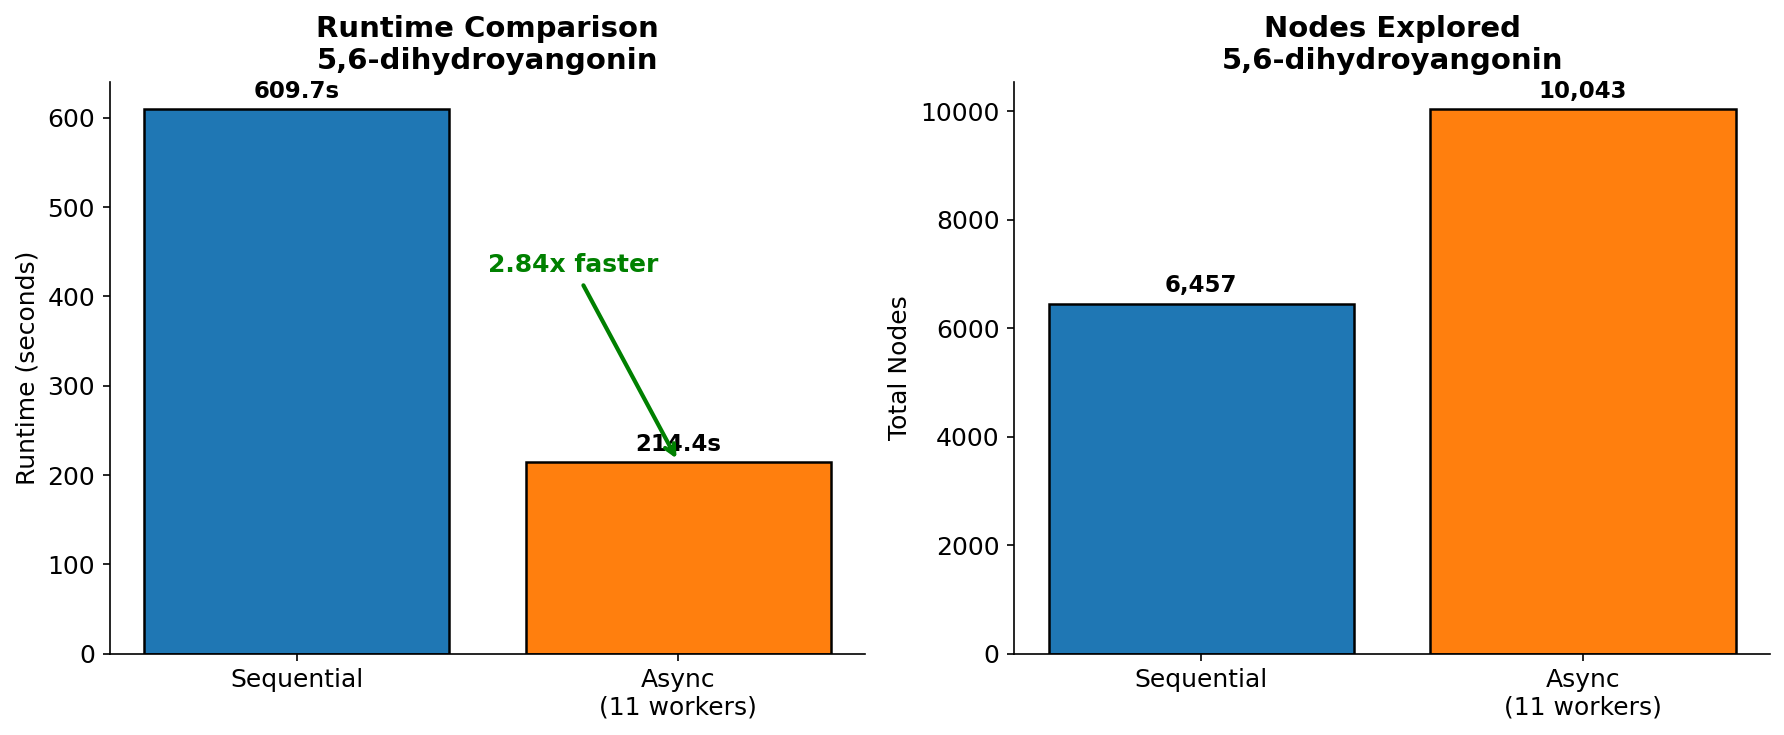

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart: Runtime comparison
ax1 = axes[0]
methods = ['Sequential', f'Async\n({num_workers} workers)']
runtimes = [seq_runtime, async_runtime]
colors = ['#1f77b4', '#ff7f0e']

bars = ax1.bar(methods, runtimes, color=colors, edgecolor='black', linewidth=1.2)
ax1.set_ylabel('Runtime (seconds)', fontsize=12)
ax1.set_title(f'Runtime Comparison\n{TARGET_NAME}', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, runtime in zip(bars, runtimes):
    height = bar.get_height()
    ax1.annotate(f'{runtime:.1f}s',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Add speedup annotation
ax1.annotate(f'{speedup:.2f}x faster',
            xy=(1, async_runtime),
            xytext=(0.5, seq_runtime * 0.7),
            fontsize=12, fontweight='bold', color='green',
            arrowprops=dict(arrowstyle='->', color='green', lw=2))

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# Bar chart: Nodes explored
ax2 = axes[1]
nodes = [seq_results['total_nodes'], async_results['total_nodes']]

bars2 = ax2.bar(methods, nodes, color=colors, edgecolor='black', linewidth=1.2)
ax2.set_ylabel('Total Nodes', fontsize=12)
ax2.set_title(f'Nodes Explored\n{TARGET_NAME}', fontsize=14, fontweight='bold')

# Add value labels on bars
for bar, n in zip(bars2, nodes):
    height = bar.get_height()
    ax2.annotate(f'{n:,}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=11, fontweight='bold')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

plt.tight_layout()

# Save figure
figures_dir = Path('../figures')
figures_dir.mkdir(parents=True, exist_ok=True)
save_path = figures_dir / 'sequential_vs_async_runtime_comparison.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 6. Throughput Comparison

Figure saved to: ../figures/sequential_vs_async_throughput.png


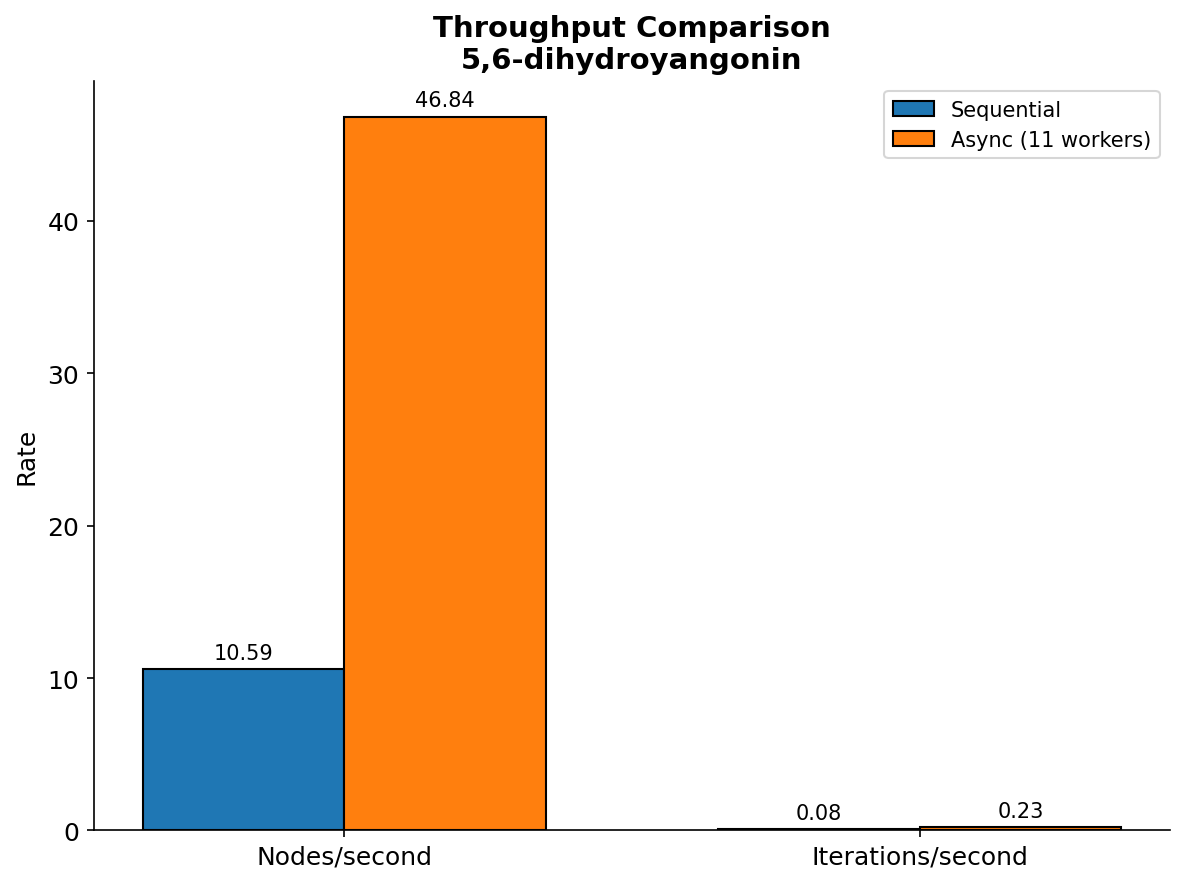

In [19]:
# Calculate throughput metrics
seq_throughput = seq_results['total_nodes'] / seq_results['runtime_seconds']
async_throughput = async_results['total_nodes'] / async_results['runtime_seconds']

seq_iter_rate = seq_results['total_iterations'] / seq_results['runtime_seconds']
async_iter_rate = async_results['total_iterations'] / async_results['runtime_seconds']

fig, ax = plt.subplots(figsize=(8, 6))

metrics = ['Nodes/second', 'Iterations/second']
seq_values = [seq_throughput, seq_iter_rate]
async_values = [async_throughput, async_iter_rate]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, seq_values, width, label='Sequential', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x + width/2, async_values, width, label=f'Async ({num_workers} workers)', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Rate', fontsize=12)
ax.set_title(f'Throughput Comparison\n{TARGET_NAME}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'sequential_vs_async_throughput.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 7. Terminal Nodes Comparison

Figure saved to: ../figures/sequential_vs_async_terminal_nodes.png


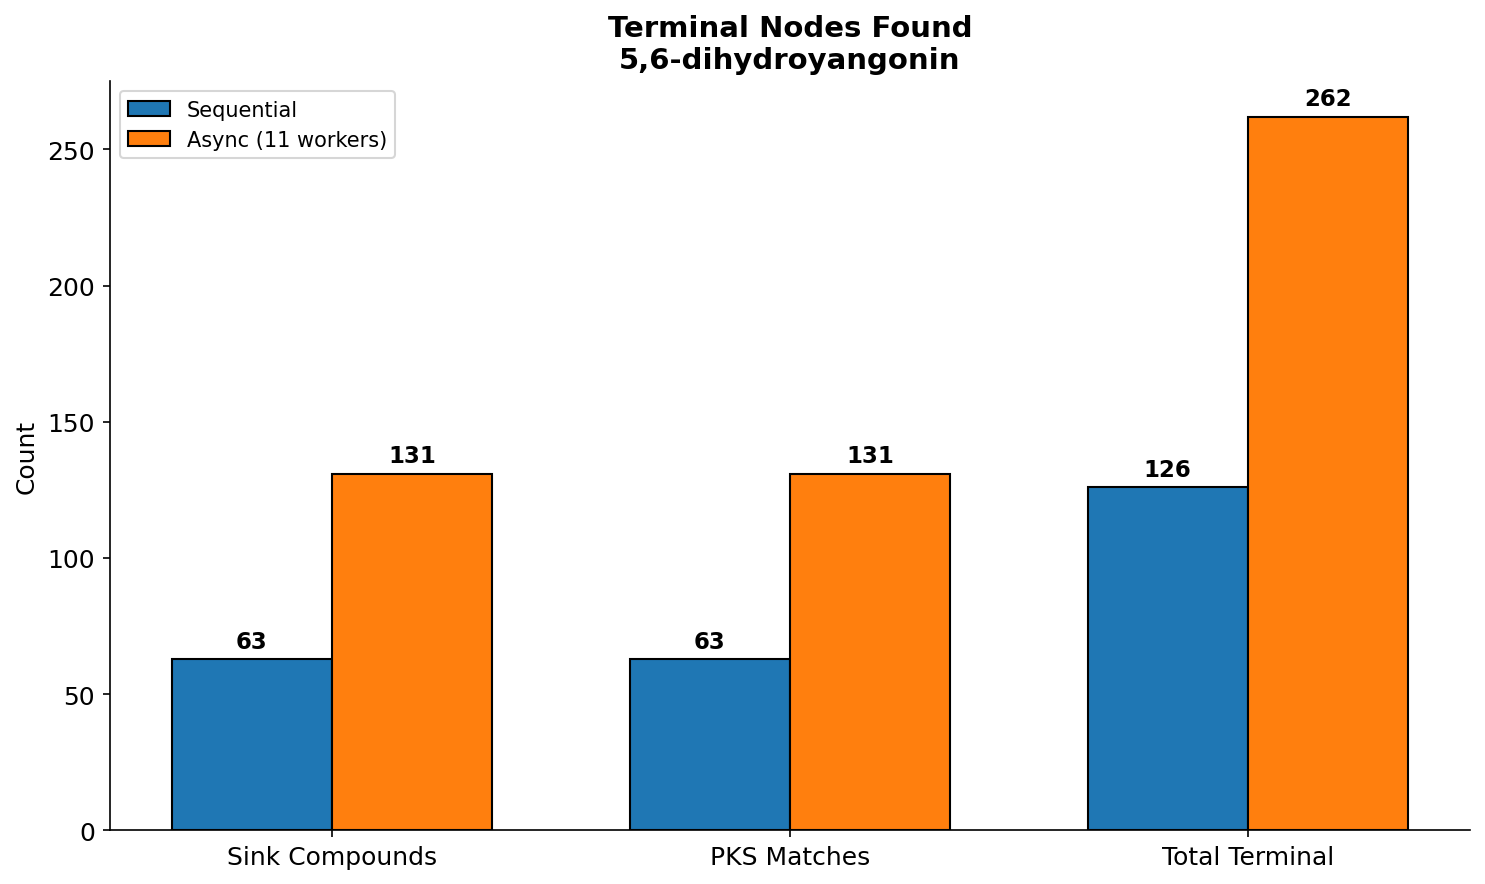

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['Sink Compounds', 'PKS Matches', 'Total Terminal']
seq_terminal = [seq_results['sink_compounds'], seq_results['pks_matches'], seq_results['terminal_nodes']]
async_terminal = [async_results['sink_compounds'], async_results['pks_matches'], async_results['terminal_nodes']]

x = np.arange(len(categories))
width = 0.35

bars1 = ax.bar(x - width/2, seq_terminal, width, label='Sequential', color='#1f77b4', edgecolor='black')
bars2 = ax.bar(x + width/2, async_terminal, width, label=f'Async ({num_workers} workers)', color='#ff7f0e', edgecolor='black')

ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Terminal Nodes Found\n{TARGET_NAME}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(categories)
ax.legend()

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

save_path = figures_dir / 'sequential_vs_async_terminal_nodes.png'
plt.savefig(save_path, dpi=300, bbox_inches='tight')
print(f"Figure saved to: {save_path}")

plt.show()

## 8. Efficiency Analysis

In [21]:
# Calculate efficiency metrics
seq_terminals_per_second = seq_results['terminal_nodes'] / seq_results['runtime_seconds']
async_terminals_per_second = async_results['terminal_nodes'] / async_results['runtime_seconds']

# Parallel efficiency: actual speedup / ideal speedup (num_workers)
ideal_speedup = num_workers if isinstance(num_workers, int) else 1
parallel_efficiency = (speedup / ideal_speedup) * 100

print("="*60)
print("EFFICIENCY ANALYSIS")
print("="*60)
print(f"\nTerminal nodes per second:")
print(f"  Sequential: {seq_terminals_per_second:.4f}")
print(f"  Async:      {async_terminals_per_second:.4f}")
print(f"  Improvement: {async_terminals_per_second / seq_terminals_per_second:.2f}x")

print(f"\nParallel efficiency:")
print(f"  Actual speedup: {speedup:.2f}x")
print(f"  Ideal speedup (with {num_workers} workers): {ideal_speedup}x")
print(f"  Parallel efficiency: {parallel_efficiency:.1f}%")

print(f"\nNote: Async explored {async_results['total_nodes'] - seq_results['total_nodes']} more nodes")
print(f"      ({(async_results['total_nodes'] / seq_results['total_nodes'] - 1) * 100:.1f}% more)")
print(f"      and found {async_results['terminal_nodes'] - seq_results['terminal_nodes']} more terminal nodes")
print(f"      ({(async_results['terminal_nodes'] / seq_results['terminal_nodes'] - 1) * 100:.1f}% more)")

EFFICIENCY ANALYSIS

Terminal nodes per second:
  Sequential: 0.2066
  Async:      1.2219
  Improvement: 5.91x

Parallel efficiency:
  Actual speedup: 2.84x
  Ideal speedup (with 11 workers): 11x
  Parallel efficiency: 25.9%

Note: Async explored 3586 more nodes
      (55.5% more)
      and found 136 more terminal nodes
      (107.9% more)


## 9. Final Summary

In [22]:
print("="*70)
print("FINAL SUMMARY: Sequential vs. Async DORAnetMCTS")
print("="*70)
print(f"\nTarget molecule: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"\nConfiguration:")
print(f"  - Iterations: {seq_results['total_iterations']}")
print(f"  - Max depth: {seq_results['max_depth']}")
print(f"  - Async workers: {num_workers}")
print(f"\nRuntime Results:")
print(f"  Sequential runtime: {seq_runtime:.2f} seconds ({seq_runtime/60:.1f} min)")
print(f"  Async runtime:      {async_runtime:.2f} seconds ({async_runtime/60:.1f} min)")
print(f"  Speedup:            {speedup:.2f}x")
print(f"  Time saved:         {seq_runtime - async_runtime:.2f} seconds ({(seq_runtime - async_runtime)/60:.1f} min)")
print(f"\nExploration Results:")
print(f"  Sequential tree nodes:   {seq_results['total_nodes']:,}")
print(f"  Async tree nodes:        {async_results['total_nodes']:,}")
if seq_results['unique_smiles'] is not None and async_results['unique_smiles'] is not None:
    print(f"  Sequential unique molecules: {seq_results['unique_smiles']:,}")
    print(f"  Async unique molecules:      {async_results['unique_smiles']:,}")
else:
    print(f"  Unique molecules: N/A (re-run benchmarks to collect this metric)")
print(f"\nTerminal Nodes Found:")
print(f"  Sequential: {seq_results['terminal_nodes']} ({seq_results['sink_compounds']} sink + {seq_results['pks_matches']} PKS)")
print(f"  Async:      {async_results['terminal_nodes']} ({async_results['sink_compounds']} sink + {async_results['pks_matches']} PKS)")
print("="*70)

FINAL SUMMARY: Sequential vs. Async DORAnetMCTS

Target molecule: 5,6-dihydroyangonin
SMILES: COC1=CC(OC(C=CC2=CC=C(OC)C=C2)C1)=O

Configuration:
  - Iterations: 50
  - Max depth: 3
  - Async workers: 11

Runtime Results:
  Sequential runtime: 609.74 seconds (10.2 min)
  Async runtime:      214.41 seconds (3.6 min)
  Speedup:            2.84x
  Time saved:         395.33 seconds (6.6 min)

Exploration Results:
  Sequential tree nodes:   6,457
  Async tree nodes:        10,043
  Unique molecules: N/A (re-run benchmarks to collect this metric)

Terminal Nodes Found:
  Sequential: 126 (63 sink + 63 PKS)
  Async:      262 (131 sink + 131 PKS)


## 10. DORAnet Synthetic Expansion (2 retro steps, no MCTS)

Run the DORAnet **synthetic** reaction network expansion directly — no MCTS tree search, just the raw `synthetic.generate_network()` call with `gen=2` retrosynthetic generations. This measures the cost of a single exhaustive expansion that the MCTS agents call repeatedly at each node.

In [ ]:
import csv

# Load chemistry helpers (cofactors/reagents for synthetic expansion)
chemistry_helpers_path = REPO_ROOT / "data/raw/chemistry_helpers.csv"
chemistry_helpers = set()

with open(chemistry_helpers_path, "r", encoding="utf-8-sig") as f:
    reader = csv.DictReader(f)
    for row in reader:
        smiles = row.get("SMILES") or row.get("smiles")
        if smiles:
            chemistry_helpers.add(smiles)

print(f"Loaded {len(chemistry_helpers)} chemistry helpers from {chemistry_helpers_path.name}")

In [ ]:
import time
import doranet.modules.synthetic as synthetic

print(f"Running DORAnet synthetic expansion (gen=2, retro) for {TARGET_NAME}...")
print(f"Target SMILES: {TARGET_SMILES}")
print(f"Chemistry helpers: {len(chemistry_helpers)}")
print()

syn_start = time.perf_counter()

syn_network = synthetic.generate_network(
    job_name="benchmark_synthetic",
    starters={TARGET_SMILES},
    gen=2,
    direction="retro",
    helpers=chemistry_helpers,
)

syn_standalone_runtime = time.perf_counter() - syn_start
syn_standalone_n_mols = len(list(syn_network.mols))
syn_standalone_n_rxns = len(list(syn_network.rxns))

print(f"Synthetic expansion complete.")
print(f"  Runtime: {syn_standalone_runtime:.2f} seconds ({syn_standalone_runtime/60:.1f} min)")
print(f"  Molecules: {syn_standalone_n_mols:,}")
print(f"  Reactions: {syn_standalone_n_rxns:,}")

In [ ]:
print("="*60)
print("DORAnet SYNTHETIC EXPANSION SUMMARY")
print("="*60)
print(f"\nTarget: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"Generations: 2 (retrosynthetic)")
print(f"Chemistry helpers: {len(chemistry_helpers)}")
print(f"\nResults:")
print(f"  Runtime:   {syn_standalone_runtime:.2f} seconds ({syn_standalone_runtime/60:.1f} min)")
print(f"  Molecules: {syn_standalone_n_mols:,}")
print(f"  Reactions: {syn_standalone_n_rxns:,}")
print("="*60)

## 11. DORAnet Enzymatic Expansion (2 retro steps, no MCTS)

Run the DORAnet **enzymatic** reaction network expansion directly with `gen=2`. Enzymatic expansions are significantly slower than synthetic (the enzymatic rule set is much larger), so we impose a **2-hour (7200 s) timeout**. If the expansion exceeds the timeout, we record the runtime as 48 hours (172,800 s) — the estimated wall-clock time from prior experience.

In [ ]:
import subprocess
import json
import sys

ENZYMATIC_TIMEOUT = 7200  # 2 hours in seconds
ENZYMATIC_FALLBACK_RUNTIME = 48 * 3600  # 48 hours in seconds

# Write a small helper script that runs enzymatic expansion and prints JSON results.
# We use subprocess instead of multiprocessing.Process because macOS uses the "spawn"
# start method, which cannot pickle functions defined in Jupyter notebook cells.
helper_script = REPO_ROOT / "_run_enzymatic_benchmark.py"
helper_script.write_text(f"""\
import time, json, sys
import doranet.modules.enzymatic as enzymatic

target_smiles = sys.argv[1]
start = time.perf_counter()
enz_network = enzymatic.generate_network(
    job_name="benchmark_enzymatic",
    starters={{target_smiles}},
    gen=2,
    direction="retro",
)
elapsed = time.perf_counter() - start
result = {{
    "runtime": elapsed,
    "n_mols": len(list(enz_network.mols)),
    "n_rxns": len(list(enz_network.rxns)),
}}
print(json.dumps(result))
""")

print(f"Running DORAnet enzymatic expansion (gen=2, retro) for {TARGET_NAME}...")
print(f"Timeout: {ENZYMATIC_TIMEOUT} seconds ({ENZYMATIC_TIMEOUT/3600:.1f} hours)")
print()

enz_wall_start = time.perf_counter()
try:
    proc_result = subprocess.run(
        [sys.executable, str(helper_script), TARGET_SMILES],
        capture_output=True,
        text=True,
        timeout=ENZYMATIC_TIMEOUT,
        cwd=str(REPO_ROOT),
    )
    enz_wall_elapsed = time.perf_counter() - enz_wall_start

    if proc_result.returncode != 0:
        print(f"Enzymatic expansion subprocess failed (exit code {proc_result.returncode}):")
        print(proc_result.stderr[-2000:] if len(proc_result.stderr) > 2000 else proc_result.stderr)
        enz_standalone_runtime = enz_wall_elapsed
        enz_standalone_n_mols = None
        enz_standalone_n_rxns = None
        enz_timed_out = False
    else:
        # Parse JSON from last line of stdout
        stdout_lines = proc_result.stdout.strip().split("\n")
        result_data = json.loads(stdout_lines[-1])
        enz_standalone_runtime = result_data["runtime"]
        enz_standalone_n_mols = result_data["n_mols"]
        enz_standalone_n_rxns = result_data["n_rxns"]
        enz_timed_out = False
        print(f"Enzymatic expansion complete.")
        print(f"  Runtime: {enz_standalone_runtime:.2f} seconds ({enz_standalone_runtime/60:.1f} min)")
        print(f"  Molecules: {enz_standalone_n_mols:,}")
        print(f"  Reactions: {enz_standalone_n_rxns:,}")

except subprocess.TimeoutExpired:
    enz_wall_elapsed = time.perf_counter() - enz_wall_start
    enz_standalone_runtime = ENZYMATIC_FALLBACK_RUNTIME
    enz_standalone_n_mols = None
    enz_standalone_n_rxns = None
    enz_timed_out = True
    print(f"Enzymatic expansion TIMED OUT after {enz_wall_elapsed:.0f} seconds.")
    print(f"Recording runtime as {ENZYMATIC_FALLBACK_RUNTIME} seconds ({ENZYMATIC_FALLBACK_RUNTIME/3600:.0f} hours).")

finally:
    # Clean up helper script
    if helper_script.exists():
        helper_script.unlink()

In [ ]:
print("="*60)
print("DORAnet ENZYMATIC EXPANSION SUMMARY")
print("="*60)
print(f"\nTarget: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print(f"Generations: 2 (retrosynthetic)")
print(f"Timeout: {ENZYMATIC_TIMEOUT} seconds ({ENZYMATIC_TIMEOUT/3600:.1f} hours)")
print(f"\nResults:")
if enz_timed_out:
    print(f"  STATUS:  TIMED OUT after {ENZYMATIC_TIMEOUT} seconds")
    print(f"  Runtime: {ENZYMATIC_FALLBACK_RUNTIME} seconds ({ENZYMATIC_FALLBACK_RUNTIME/3600:.0f} hours) [estimated]")
else:
    print(f"  STATUS:  Completed")
    print(f"  Runtime: {enz_standalone_runtime:.2f} seconds ({enz_standalone_runtime/60:.1f} min)")
    if enz_standalone_n_mols is not None:
        print(f"  Molecules: {enz_standalone_n_mols:,}")
    if enz_standalone_n_rxns is not None:
        print(f"  Reactions: {enz_standalone_n_rxns:,}")
print("="*60)

## 12. Cleanup `.pgnet` Files

DORAnet `generate_network()` writes `.pgnet` files to disk. Clean them up.

In [ ]:
import glob as glob_module

# Search for .pgnet files in the notebook directory and repo root
pgnet_patterns = [
    str(Path(".").resolve() / "*.pgnet"),
    str(REPO_ROOT / "*.pgnet"),
    str(REPO_ROOT / "**/*.pgnet"),
]

pgnet_files = set()
for pattern in pgnet_patterns:
    pgnet_files.update(glob_module.glob(pattern, recursive=True))

if pgnet_files:
    print(f"Found {len(pgnet_files)} .pgnet file(s) to clean up:")
    for f in sorted(pgnet_files):
        fpath = Path(f)
        size_mb = fpath.stat().st_size / (1024 * 1024)
        print(f"  {fpath.name} ({size_mb:.1f} MB)")
        fpath.unlink()
    print(f"\nDeleted {len(pgnet_files)} .pgnet file(s).")
else:
    print("No .pgnet files found. Nothing to clean up.")

## 13. Combined Runtime Comparison

Compare all three runtimes:
1. **TridentSynth MCTS Sequential** — full MCTS tree search (sequential)
2. **TridentSynth MCTS Async** — full MCTS tree search (parallel workers)
3. **DORAnet Standalone** — raw `generate_network()` for both synthetic and enzymatic modes (2 retro generations), summed together

In [ ]:
# Combined DORAnet standalone runtime (synthetic + enzymatic)
doranet_standalone_runtime = syn_standalone_runtime + enz_standalone_runtime
doranet_standalone_timed_out = enz_timed_out

# Build the 3-way comparison DataFrame
combined_df = pd.DataFrame({
    "Method": [
        "TridentSynth MCTS Sequential",
        "TridentSynth MCTS Async",
        "DORAnet Standalone (2 retro steps)",
    ],
    "Runtime (s)": [
        seq_runtime,
        async_runtime,
        doranet_standalone_runtime,
    ],
    "Notes": [
        f"{seq_results['total_iterations']} iterations, depth {seq_results['max_depth']}, 1 worker",
        f"{async_results['total_iterations']} iterations, depth {async_results['max_depth']}, {num_workers} workers",
        (
            f"synthetic {syn_standalone_runtime:.1f}s + enzymatic {enz_standalone_runtime:.1f}s"
            if not enz_timed_out
            else f"synthetic {syn_standalone_runtime:.1f}s + enzymatic TIMED OUT ({ENZYMATIC_FALLBACK_RUNTIME/3600:.0f}h est.)"
        ),
    ],
})

display(combined_df)

In [ ]:
# 3-way runtime bar chart
fig, ax = plt.subplots(figsize=(10, 6))

labels = [
    "TridentSynth\nMCTS Sequential",
    "TridentSynth\nMCTS Async",
    "DORAnet Standalone\n(2 retro steps)",
]
runtimes_all = [seq_runtime, async_runtime, doranet_standalone_runtime]
colors_all = ["#1f77b4", "#ff7f0e", "#2ca02c"]

# Use log scale if DORAnet runtime is much larger than the others
use_log = doranet_standalone_runtime > 10 * max(seq_runtime, async_runtime)

bars = ax.bar(labels, runtimes_all, color=colors_all, edgecolor="black", linewidth=1.2)

if use_log:
    ax.set_yscale("log")
    ax.set_ylabel("Runtime (seconds, log scale)", fontsize=12)
else:
    ax.set_ylabel("Runtime (seconds)", fontsize=12)

ax.set_title(
    f"Runtime Comparison — {TARGET_NAME}",
    fontsize=14, fontweight="bold",
)

# Annotate bars
for bar, rt, label in zip(bars, runtimes_all, labels):
    height = bar.get_height()
    if rt >= 3600:
        time_str = f"{rt/3600:.1f}h"
    elif rt >= 60:
        time_str = f"{rt/60:.1f}m"
    else:
        time_str = f"{rt:.1f}s"

    if "DORAnet" in label and doranet_standalone_timed_out:
        time_str += "\n(includes\ntimeout est.)"

    ax.annotate(
        time_str,
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 5 if use_log else 3),
        textcoords="offset points",
        ha="center", va="bottom", fontsize=11, fontweight="bold",
    )

# If DORAnet includes a timeout estimate, hatch the bar
if doranet_standalone_timed_out:
    bars[2].set_hatch("//")
    bars[2].set_edgecolor("black")

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

plt.tight_layout()

mol_name_safe = TARGET_NAME.replace(",", "").replace(" ", "_").replace("-", "_")
save_path = figures_dir / f"runtime_comparison_{mol_name_safe}.png"
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print(f"Figure saved to: {save_path}")

plt.show()

In [ ]:
print("="*70)
print("FINAL 3-WAY RUNTIME COMPARISON")
print("="*70)
print(f"\nTarget molecule: {TARGET_NAME}")
print(f"SMILES: {TARGET_SMILES}")
print()

def fmt_runtime(seconds, timed_out=False):
    if timed_out:
        return f"{seconds/3600:.0f} hours (includes timeout estimate)"
    elif seconds >= 3600:
        return f"{seconds:.2f}s ({seconds/3600:.1f} hours)"
    elif seconds >= 60:
        return f"{seconds:.2f}s ({seconds/60:.1f} min)"
    else:
        return f"{seconds:.2f}s"

print(f"  1. TridentSynth MCTS Sequential:     {fmt_runtime(seq_runtime)}")
print(f"  2. TridentSynth MCTS Async:           {fmt_runtime(async_runtime)}")
print(f"  3. DORAnet Standalone (2 retro gen):  {fmt_runtime(doranet_standalone_runtime, doranet_standalone_timed_out)}")
print(f"     (synthetic: {syn_standalone_runtime:.1f}s + enzymatic: {enz_standalone_runtime:.1f}s)")

print()
print("Key takeaways:")
print(f"  - Async MCTS is {seq_runtime/async_runtime:.2f}x faster than sequential MCTS")

if doranet_standalone_runtime > seq_runtime:
    print(f"  - DORAnet standalone is {doranet_standalone_runtime/seq_runtime:.1f}x slower than sequential MCTS")
    print(f"    and {doranet_standalone_runtime/async_runtime:.1f}x slower than async MCTS")
elif doranet_standalone_runtime > async_runtime:
    print(f"  - DORAnet standalone is faster than sequential MCTS but")
    print(f"    {doranet_standalone_runtime/async_runtime:.1f}x slower than async MCTS")
else:
    print(f"  - DORAnet standalone is faster than both MCTS variants")

print("="*70)